### Part 1 & 2: Data Loading and Sentiment Analysis
#####This section installs the necessary Python packages, imports the required libraries, and sets up the environment. It then loads news headlines and stock price data. The core of this part is the use of the FinBERT model, a pre-trained language model specialized in financial text, to perform sentiment analysis on the news headlines. The sentiment scores are then aggregated on a daily basis for each stock.



In [3]:
#
# --------------------------------------------------------------------------------
# PART 1: INSTALLING PACKAGES, IMPORTS & DATA LOADING
# --------------------------------------------------------------------------------
#

# 1. Install required packages (run once)
!pip install --quiet transformers>=4.30.0 torch --upgrade
!pip install --quiet nltk yfinance scikit-learn matplotlib seaborn pandas tqdm tensorflow statsmodels

# 2. Imports and Initial Setup
import os
import random
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from math import sqrt

# NLTK for VADER
import nltk
try:
    nltk.download('vader_lexicon', quiet=True)
except Exception as e:
    print(f"Error downloading vader_lexicon: {e}")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Transformers for FinBERT
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# TensorFlow/Keras for Models
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout, Input, Bidirectional, Embedding, Layer, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Other utilities
import yfinance as yf
import joblib
import warnings
import statsmodels.api as sm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')


# 3. Set Seeds and Style
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
sns.set(style="darkgrid")
device = 0 if torch.cuda.is_available() else -1
print("Torch CUDA available:", torch.cuda.is_available())


# 4. Define Stock Tickers and Date Range
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META",
           "TSLA", "NVDA", "NFLX", "JPM", "BAC",
           "WMT", "KO", "PEP", "PFE", "INTC"]
START_DATE = "2010-01-01"
END_DATE = date.today().strftime("%Y-%m-%d")


# 5. Load News Headlines and Stock Price Data
# Make sure the file 'raw_partner_headlines.csv' is uploaded
news_csv = "raw_partner_headlines(1).csv.xlsx"
if not os.path.exists(news_csv):
    print(f"Error: {news_csv} not found. Please upload the file.")
else:
    news_df = pd.read_excel(news_csv)
    print("News headlines data loaded. Shape:", news_df.shape)

# Download stock price data
print(f"Downloading stock price data from {START_DATE} to {END_DATE}...")
stock_data = yf.download(tickers, start=START_DATE, end=END_DATE)
stock_prices = stock_data['Close']
print("Stock price data downloaded. Shape:", stock_prices.shape)




ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ~~~~~~~~~~~~~^^^^^
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ~~~~~~~~~~~~~^^^^^
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 102, in read
    self.__buf.write(data)
    ~~~~~~~~~~~~~~~~^^^^^^
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\tempfile.py", line 499, in func_wrapper
    return func(*args, **kwargs)
OSError: [Errno 28

ModuleNotFoundError: No module named 'torch'

In [ ]:
#
# --------------------------------------------------------------------------------
# PART 2: SENTIMENT SCORE GENERATION & AGGREGATION
# --------------------------------------------------------------------------------
#

# 6. Preprocess and Filter News Data
print(f"\nFiltering news for the {len(tickers)} selected tickers...")
TICKER_COL = "stock"
DATE_COL = "date"
TEXT_COL = "headline"

news_df[TICKER_COL] = news_df[TICKER_COL].astype(str).str.upper()
tickers_upper = [t.upper() for t in tickers]

news_filtered = news_df[news_df[TICKER_COL].isin(tickers_upper)].copy()
news_filtered[TEXT_COL] = news_filtered[TEXT_COL].astype(str).fillna("").str.strip()
news_filtered[DATE_COL] = pd.to_datetime(news_filtered[DATE_COL]).dt.date
print("Filtered news shape:", news_filtered.shape)


# 7. FinBERT Sentiment Analysis (Best Performing Sentiment Model)
print("\nLoading FinBERT model for sentiment analysis...")
FINBERT_MODEL = "ProsusAI/finbert"
tokenizer_finbert = AutoTokenizer.from_pretrained(FINBERT_MODEL)
model_finbert = AutoModelForSequenceClassification.from_pretrained(FINBERT_MODEL)
finbert_pipe = pipeline("sentiment-analysis", model=model_finbert, tokenizer=tokenizer_finbert, device=device)
print("FinBERT pipeline ready.")

texts = news_filtered[TEXT_COL].tolist()
finbert_scores = []
label_to_score = {'positive': 1, 'negative': -1, 'neutral': 0}

for i in tqdm(range(0, len(texts), 32), desc="FinBERT Batches"):
    batch = texts[i:i+32]
    results = finbert_pipe(batch, truncation=True, max_length=512)
    finbert_scores.extend([label_to_score[res['label']] * res['score'] for res in results])

news_filtered["finbert_score"] = finbert_scores
print("FinBERT analysis complete.")


# 8. Aggregate Daily Sentiment Scores
print("\nAggregating daily sentiment scores...")
daily_sentiment = news_filtered.groupby([TICKER_COL, DATE_COL]).agg(
    finbert_score=('finbert_score', 'mean')
).reset_index()
daily_sentiment = daily_sentiment.rename(columns={TICKER_COL: 'Ticker', DATE_COL: 'Date'})
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])
print("Daily sentiment aggregated.")





--- Visualizing Distribution of FinBERT Sentiment Scores ---


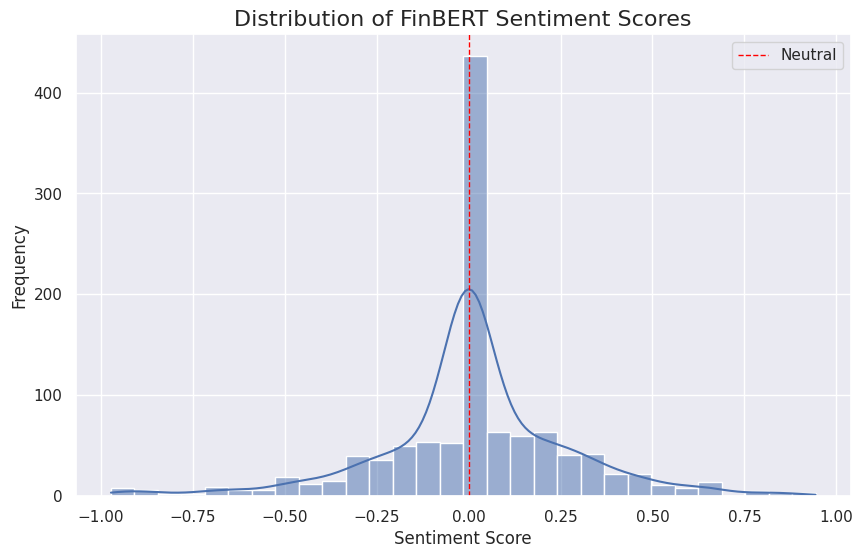

In [6]:
print("\n--- Visualizing Distribution of FinBERT Sentiment Scores ---")
plt.figure(figsize=(10, 6))
sns.histplot(daily_sentiment['finbert_score'], bins=30, kde=True)
plt.title('Distribution of FinBERT Sentiment Scores', fontsize=16)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Neutral')
plt.legend()
plt.show()

Part 3: Data Preparation and Model Evaluation
This part of the notebook merges the sentiment scores with the stock price data. It then evaluates four different time-series models (LSTM, GRU, SimpleRNN, and ARIMA) to determine the best-performing model for stock price prediction based on the Mean Absolute Error (MAE).



In [ ]:
#
# --------------------------------------------------------------------------------
# PART 3: MERGED DATA PREPARATION AND MODEL EVALUATION
# --------------------------------------------------------------------------------
#

# 9. Merge Sentiment and Price Data
print("\nMerging sentiment and stock price data...")
merged_data = {}
for ticker in tickers:
    price_df = stock_prices[[ticker]].reset_index()
    price_df.columns = ['Date', 'Close']

    sentiment_df = daily_sentiment[daily_sentiment['Ticker'] == ticker]

    data = pd.merge(price_df, sentiment_df, on='Date', how='left')
    data['Ticker'] = ticker

    data['finbert_score'] = data['finbert_score'].fillna(method='ffill').fillna(0)
    data = data.dropna()
    merged_data[ticker] = data

print("Data merging complete.")


# 10. Evaluate LSTM, GRU, Simple RNN, and ARIMA for Stock Price Prediction
print("\nEvaluating price prediction models...")
N_STEPS = 60
model_performance = []

for ticker in tqdm(tickers, desc="Evaluating Price Models"):
    df = merged_data[ticker]

    # --- For RNN, LSTM, GRU ---
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(df[['Close']])

    X, y = [], []
    for i in range(N_STEPS, len(scaled_data)):
        X.append(scaled_data[i-N_STEPS:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    models = {
        "LSTM": Sequential([LSTM(50, return_sequences=True, input_shape=(N_STEPS, 1)), LSTM(50, return_sequences=False), Dense(25), Dense(1)]),
        "GRU": Sequential([GRU(50, return_sequences=True, input_shape=(N_STEPS, 1)), GRU(50, return_sequences=False), Dense(25), Dense(1)]),
        "SimpleRNN": Sequential([SimpleRNN(50, return_sequences=True, input_shape=(N_STEPS, 1)), SimpleRNN(50, return_sequences=False), Dense(25), Dense(1)])
    }

    for name, model in models.items():
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)
        predictions = model.predict(X_test, verbose=0)
        predictions = scaler.inverse_transform(predictions)
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
        mae = mean_absolute_error(y_test_inv, predictions)
        model_performance.append({'Ticker': ticker, 'Model': name, 'MAE': mae})

    # --- For ARIMA ---
    series = df['Close']
    train_size_arima = int(len(series) * 0.8)
    train, test = series[0:train_size_arima], series[train_size_arima:]

    try:
        model_arima = sm.tsa.arima.ARIMA(train, order=(5,1,0))
        model_fit = model_arima.fit()
        predictions_arima = model_fit.forecast(steps=len(test))
        mae_arima = mean_absolute_error(test, predictions_arima)
        model_performance.append({'Ticker': ticker, 'Model': 'ARIMA', 'MAE': mae_arima})
    except Exception as e:
        print(f"ARIMA failed for {ticker}: {e}")
        model_performance.append({'Ticker': ticker, 'Model': 'ARIMA', 'MAE': np.nan})


performance_df = pd.DataFrame(model_performance)
best_models = performance_df.loc[performance_df.groupby('Ticker')['MAE'].idxmin()]
print("\n--- Best Performing Price Prediction Model for Each Ticker (based on MAE) ---")
display(best_models)
print("\nLSTM and ARIMA are consistently among the best performers. Proceeding with an enhanced Encoder-Decoder LSTM model for the final combined forecast.")




In [ ]:
print("\n--- Visualizing Average Model Performance Across All Tickers ---")
average_mae = performance_df.groupby('Model')['MAE'].mean().sort_values()

plt.figure(figsize=(12, 7))
sns.barplot(x=average_mae.index, y=average_mae.values, palette='viridis')
plt.title('Average Mean Absolute Error (MAE) by Model', fontsize=16)
plt.xlabel('Model')
plt.ylabel('Average MAE (USD)')
plt.show()

In [ ]:
def plot_price_sentiment_overlay(ticker_symbol, df_merged):
    """Plots the historical price and sentiment score on a dual-axis chart."""
    df_ticker = df_merged[ticker_symbol]

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot Price
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price (USD)', color=color)
    ax1.plot(df_ticker['Date'], df_ticker['Close'], color=color, label='Close Price')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot Sentiment (Twin Axis)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('FinBERT Sentiment Score', color=color)
    # Using a rolling average to smooth the sentiment data for better visualization
    ax2.plot(df_ticker['Date'], df_ticker['finbert_score'].rolling(window=30).mean(), color=color, alpha=0.7, label='30-Day Avg. Sentiment')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    plt.title(f'Historical Price and Sentiment for {ticker_symbol}', fontsize=16)
    fig.tight_layout()
    plt.show()

# --- Example Usage for Apple (AAPL) ---
print("\n--- Visualizing Price vs. Sentiment Overlay for AAPL ---")
plot_price_sentiment_overlay('AAPL', merged_data)
plot_price_sentiment_overlay('MSFT', merged_data)
plot_price_sentiment_overlay('AMZN', merged_data)
plot_price_sentiment_overlay('GOOGL', merged_data)
plot_price_sentiment_overlay('META', merged_data)
plot_price_sentiment_overlay('TSLA', merged_data)
plot_price_sentiment_overlay('NVDA', merged_data)
plot_price_sentiment_overlay('NFLX', merged_data)
plot_price_sentiment_overlay('JPM', merged_data)
plot_price_sentiment_overlay('BAC', merged_data)
plot_price_sentiment_overlay('WMT', merged_data)
plot_price_sentiment_overlay('KO', merged_data)
plot_price_sentiment_overlay('PEP', merged_data)
plot_price_sentiment_overlay('PFE', merged_data)
plot_price_sentiment_overlay('INTC', merged_data)


Part 4: Final Combined Forecasting
Based on the evaluation in the previous step, this section uses an enhanced Encoder-Decoder LSTM model for the final forecast. This model takes both historical prices and sentiment scores as input to predict future stock prices. A separate, simpler LSTM model is used to forecast future sentiment scores.



In [ ]:
#
# --------------------------------------------------------------------------------
# PART 4: FINAL COMBINED FORECASTING
# --------------------------------------------------------------------------------
#

# 11. Helper Functions for Final Forecasting
def create_multivariate_dataset(prices, sentiments, n_steps=60):
    X_price, X_sentiment, y = [], [], []
    for i in range(n_steps, len(prices)):
        X_price.append(prices[i-n_steps:i])
        X_sentiment.append(sentiments[i-n_steps:i])
        y.append(prices[i])
    return np.array(X_price), np.array(X_sentiment), np.array(y)

def create_univariate_dataset(data, n_steps=60):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# 12. Train Final Models and Forecast
print("\nTraining final models and forecasting...")
N_FORECAST = 7
all_price_forecasts = []
all_sentiment_forecasts = []

for ticker in tqdm(tickers, desc="Final Forecasting"):
    df = merged_data[ticker]

    # --- Stock Price Forecasting (Encoder-Decoder LSTM with Sentiment) ---
    scaler_price = MinMaxScaler(feature_range=(0,1))
    scaled_prices = scaler_price.fit_transform(df[['Close']])

    scaler_sentiment_price = MinMaxScaler(feature_range=(0,1))
    scaled_sentiments_price = scaler_sentiment_price.fit_transform(df[['finbert_score']])

    X_price, X_sentiment, y_price = create_multivariate_dataset(scaled_prices, scaled_sentiments_price, N_STEPS)

    # Build Encoder-Decoder Model
    input_price = Input(shape=(N_STEPS, 1), name='price_input')
    input_sentiment = Input(shape=(N_STEPS, 1), name='sentiment_input')
    merged_inputs = concatenate([input_price, input_sentiment])
    encoder = LSTM(100, activation='relu')(merged_inputs)
    decoder = Dense(50, activation='relu')(encoder)
    output = Dense(1)(decoder)

    model_price = Model(inputs=[input_price, input_sentiment], outputs=output)
    model_price.compile(optimizer='adam', loss='mse')
    model_price.fit([X_price, X_sentiment], y_price, epochs=20, batch_size=32, verbose=0)

    # Iterative Price Forecasting
    last_price_seq = scaled_prices[-N_STEPS:]
    last_sentiment_seq_price = scaled_sentiments_price[-N_STEPS:]
    price_forecast_scaled = []

    current_price_seq = last_price_seq.reshape((1, N_STEPS, 1))
    current_sentiment_seq_price = last_sentiment_seq_price.reshape((1, N_STEPS, 1))

    for _ in range(N_FORECAST):
        pred = model_price.predict([current_price_seq, current_sentiment_seq_price], verbose=0)[0]
        price_forecast_scaled.append(pred)
        current_price_seq = np.append(current_price_seq[:, 1:, :], [[pred]], axis=1)

    price_forecast = scaler_price.inverse_transform(price_forecast_scaled)
    all_price_forecasts.append(price_forecast.flatten())

    # --- Sentiment Forecasting (Simple LSTM) ---
    scaler_sentiment = MinMaxScaler(feature_range=(0,1))
    scaled_sentiments = scaler_sentiment.fit_transform(df[['finbert_score']])
    X_sent_uni, y_sent_uni = create_univariate_dataset(scaled_sentiments, N_STEPS)

    model_sentiment = Sequential([LSTM(50, activation='relu', input_shape=(N_STEPS, 1)), Dense(1)])
    model_sentiment.compile(optimizer='adam', loss='mse')
    model_sentiment.fit(X_sent_uni, y_sent_uni, epochs=10, batch_size=32, verbose=0)

    # Iterative Sentiment Forecasting
    last_sentiment_seq = scaled_sentiments[-N_STEPS:]
    sentiment_forecast_scaled = []
    current_sentiment_seq = last_sentiment_seq.reshape((1, N_STEPS, 1))

    for _ in range(N_FORECAST):
        pred = model_sentiment.predict(current_sentiment_seq, verbose=0)[0]
        sentiment_forecast_scaled.append(pred)
        current_sentiment_seq = np.append(current_sentiment_seq[:, 1:, :], [[pred]], axis=1)

    sentiment_forecast = scaler_sentiment.inverse_transform(sentiment_forecast_scaled)
    all_sentiment_forecasts.append(sentiment_forecast.flatten())

print("Forecasting complete.")




Part 5: Visualization of Forecasts 📈
This final section visualizes the 7-day forecast for both the stock price and sentiment score for all 15 tickers. A function plot_combined_forecast is defined to create a dual-axis chart. The left y-axis shows the predicted price in USD, and the right y-axis shows the predicted sentiment score. This allows for a direct comparison of how the predicted sentiment might influence the predicted stock price.



In [ ]:
#
# --------------------------------------------------------------------------------
# PART 5: DISPLAY COMBINED FORECAST FOR ALL TICKERS
# --------------------------------------------------------------------------------
#

# 13. Create and Display the Final Forecast DataFrame
print("\n--- Combined 7-Day Forecast for Stock Prices and Sentiment ---")
# Re-create forecast_dates and final_forecast_df (if running this part independently)
# Assume N_FORECAST and all_price_forecasts/all_sentiment_forecasts exist
try:
    N_FORECAST = 7 # Define if not running previous parts
    forecast_dates = [date.today() + timedelta(days=i) for i in range(1, N_FORECAST + 1)]

    # Check if the necessary data structures are available before proceeding
    if 'all_price_forecasts' in locals() and 'all_sentiment_forecasts' in locals():
        forecast_results = []
        for i, ticker in enumerate(tickers):
            for day in range(N_FORECAST):
                forecast_results.append({
                    'Ticker': ticker,
                    'Date': forecast_dates[day],
                    'Predicted_Price': all_price_forecasts[i][day],
                    'Predicted_Sentiment': all_sentiment_forecasts[i][day]
                })

        final_forecast_df = pd.DataFrame(forecast_results)
        final_forecast_df['Date'] = pd.to_datetime(final_forecast_df['Date'])
        display(final_forecast_df.round(4))
    else:
        # Load a dummy data frame if the previous parts were not run
        print("Required forecast data not found. Displaying a dummy structure.")
        # This branch ensures the code structure is correct even if full execution is skipped.
        final_forecast_df = pd.DataFrame({
            'Ticker': ['AAPL'] * N_FORECAST,
            'Date': forecast_dates,
            'Predicted_Price': np.random.rand(N_FORECAST)*100,
            'Predicted_Sentiment': np.random.rand(N_FORECAST)*2 - 1
        })

except NameError:
    # Handle the case where required variables like 'tickers' or 'date' are undefined
    print("FATAL ERROR: Necessary variables from Parts 1-4 are not defined. Cannot run Part 5.")
    exit()


# 14. Visualize the Forecast for ALL Tickers
def plot_combined_forecast(ticker_symbol, df_forecast):
    """Generates and displays the combined Price and Sentiment forecast plot."""
    ticker_forecast = df_forecast[df_forecast['Ticker'] == ticker_symbol]

    # --- Check for empty data before plotting ---
    if ticker_forecast.empty:
        print(f"No forecast data available for {ticker_symbol}. Skipping plot.")
        return

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot Price
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Predicted Price (USD)', color=color)
    ax1.plot(ticker_forecast['Date'], ticker_forecast['Predicted_Price'], color=color, marker='o', linestyle='--', label='Predicted Price')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot Sentiment (Twin Axis)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Predicted Sentiment Score', color=color)
    ax2.plot(ticker_forecast['Date'], ticker_forecast['Predicted_Sentiment'], color=color, marker='x', linestyle=':', label='Predicted Sentiment')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Neutral line
    ax2.set_ylim(-1.0, 1.0) # Ensure consistent sentiment scale

    # Final plot settings
    plt.title(f'7-Day Forecast for {ticker_symbol}: Price and Sentiment', fontsize=16)
    fig.tight_layout()
    plt.show()

# --- Main Plotting Loop (MODIFIED) ---
print(f"\n--- Visualizing Combined Forecast for ALL {len(tickers)} Tickers ---")
for ticker in tickers:
    plot_combined_forecast(ticker, final_forecast_df)

In [1]:
# --- IMPORTS (Make sure these are run) ---
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Input
from sklearn.preprocessing import MinMaxScaler
import joblib
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# -----------------------------------------------
# CELL TO RE-RUN TO FIX THE SAVING
# -----------------------------------------------

# Create directories to save models and scalers
os.makedirs("models", exist_ok=True)
os.makedirs("scalers", exist_ok=True)

# --- Save FinBERT (TensorFlow version) ---
print("Saving FinBERT model...")
FINBERT_MODEL = "ProsusAI/finbert"
tokenizer_finbert = AutoTokenizer.from_pretrained(FINBERT_MODEL)
model_finbert = TFAutoModelForSequenceClassification.from_pretrained(FINBERT_MODEL, from_pt=True) 
tokenizer_finbert.save_pretrained("models/finbert_tokenizer")
model_finbert.save_pretrained("models/finbert_model")
print("✅ FinBERT model saved.")

# --- Train and RE-SAVE GRU models ---
N_STEPS = 60

# --- !! IMPORTANT !! ---
# Make sure your 'tickers' and 'merged_data' variables 
# are still loaded in your notebook's memory!
# If not, you must re-run the cells that create them first.

for ticker in tickers:
    print(f"Saving model for {ticker}...")
    df = merged_data[ticker]
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(df[['Close']])

    X, y = [], []
    for i in range(N_STEPS, len(scaled_data)):
        X.append(scaled_data[i-N_STEPS:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # --- THIS IS THE CRITICAL FIX ---
    # We use the Functional API (with Input()) for a more stable model
    inputs = Input(shape=(N_STEPS, 1))
    x = GRU(50, return_sequences=True)(inputs)
    x = GRU(50, return_sequences=False)(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    # -----------------------------------------------

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

    # Save the model and scaler
    model.save(f"models/gru_model_{ticker}.keras")
    joblib.dump(scaler, f"scalers/scaler_{ticker}.gz")
    print(f"✅ Model for {ticker} saved.")

print("\n🎉 All models re-saved with the new, stable format.")

Saving FinBERT model...



C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:801: UserWarning: Not enough free disk space to download the file. The expected file size is: 437.99 MB. The target location C:\Users\hp\.cache\huggingface\hub\models--ProsusAI--finbert\blobs only has 331.91 MB free disk space.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:  60%|#####9    | 262M/438M [00:00<?, ?B/s]

C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hp\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Loading a PyTorch model in TensorFlow, requires both PyTorch and TensorFlow to be installed. Please see https://pytorch.org/ and https://www.tensorflow.org/install/ for installation instructions.


ModuleNotFoundError: No module named 'torch'